<a href="https://colab.research.google.com/github/chriswmann/driven-data-pump-it-up/blob/master/driven_data_pymp_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driven Data Pump It Up.

## Introduction

This notebook contains my attempt at the [Driven Data](https://www.drivendata.org) Pump It Up Data Mining the Water Table competition \[1\].  The competition goal is to predict the operating condition of a waterpoint for each record in the dataset.

## Features

The data provided about the waterpoints is:

*amount_tsh* - Total static head (amount water available to waterpoint)

*date_recorded* - The date the row was entered

*funder* - Who funded the well

*gps_height* - Altitude of the well

*installer* - Organization that installed the well

*longitude - GPS coordinate

*latitude* - GPS coordinate

*wpt_name* - Name of the waterpoint if there is one

*num_private* - \[Undefined\]

*basin* - Geographic water basin

*subvillage* - Geographic location

*region* - Geographic location

*region_code* - Geographic location (coded)

*district_code - Geographic location (coded)

*lga* - Geographic location

*ward* - Geographic location

*population* - Population around the well

*public_meeting* - True/False

*recorded_by* - Group entering this row of data

*scheme_management* - Who operates the waterpoint

*scheme_name* - Who operates the waterpoint

*permit* - If the waterpoint is permitted

*construction_year* - Year the waterpoint was constructed

*extraction_type* - The kind of extraction the waterpoint uses

*extraction_type_group* - The kind of extraction the waterpoint uses

*extraction_type_class* - The kind of extraction the waterpoint uses

*management* - How the waterpoint is managed

*management_group* - How the waterpoint is managed

*payment* - What the water costs

*payment_type* - What the water costs

*water_quality* - The quality of the water

*quality_group* - The quality of the water

*quantity* - The quantity of water

*quantity_group* - The quantity of water

*source* - The source of the water

*source_type* - The source of the water

*source_class* - The source of the water

*waterpoint_type* - The kind of waterpoint

*waterpoint_type_group* - The kind of waterpoint

The large number of features presents some challenges, especially in terms of dimensionality and risk of colinearity.  Feature engineering, as well as selection will be required in order to obtain a good result.

## Labels

The labels in the dataset are simple. There are three possible values:

*functional* - the waterpoint is operational and there are no repairs needed
*functional needs repair* - the waterpoint is operational, but needs repairs
*non functional* - the waterpoint is not operational


### Label Distribution

![Label Distribution](http://drivendata.materials.s3.amazonaws.com/pumps/labeldistribution.png)

The large imbalance between the classes increases the difficulty of this competition.  

#### Notebook Status
Currently a work in progress.  Improvements are required in order to improve my rank from 1300 / 7002!

1. Minimal feature engineering and no feature selection.  Consequently train time for the SVMs is very high and so there is limited hyperparameter optimisation.
2. Some remnants from problems during development to this stage (e.g. the *reduce_mem_usage* function may no longer be required.)

___
## References:
1. https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

In [0]:
def reduce_mem_usage(data, verbose=False):
    """ iterates through all the columns of a dataframe, modifying the data 
    types to reduce memory usage.        
    """

    if isinstance(data, pd.DataFrame):
        columns = list(data.columns.values)
    else:
        try:
            data = pd.DataFrame(data)
        except NameError:
            print('Function expects a pandas dataframe or numpy array.  Cannot proceed.')
            assert False
        columns = None

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage of object is {start_mem:.2f} MB')

    for col in data.columns:
        col_type = data[col].dtype
        if col_type == np.number:
            c_min = data[col].min()
            c_max = data[col].max()
            if isinstance(col_type, np.int):
                print(here)
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float64).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    
    if isinstance(data, pd.DataFrame) and isinstance(columns, list):
        data.columns = columns
    
    if verbose:
        print(f'Memory usage after optimization is: {end_mem:.2f} MB')
        print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return data

In [0]:
train_values_url = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
train_labels_url = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
test_values_url = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
submission_format_url = 'https://s3.amazonaws.com/drivendata/data/7/public/SubmissionFormat.csv'

In [0]:
train_vals = pd.read_csv(train_values_url)
train_labs = pd.read_csv(train_labels_url)
test = pd.read_csv(test_values_url)
submission_format = pd.read_csv(submission_format_url)

In [5]:
train_vals.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [6]:
train_vals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [7]:
train_labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [8]:
train = train_vals.merge(train_labs, on='id')
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Set status_group column in the test set to 'test' as a label to separate the test data after pre-processing.

In [0]:
test['status_group'] = 'test'

In [10]:
full = pd.concat([train, test], axis=0)
full = full.reset_index(drop=True)
full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [11]:
full.tail()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
74245,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,test
74246,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,test
74247,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,test
74248,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,test
74249,68707,0.0,2013-02-13,Government Of Tanzania,481,Government,34.765054,-11.226012,Kwa Mzee Chagala,0,...,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,test


In [0]:
def unique_info(df):
    for col in df.columns:
        print(f'Column: {col}')
        if len(df[col].unique()) < 10:
            print(df[col].unique())
        else:
            print(len(df[col].unique()))

In [13]:
unique_info(full)

Column: id
74250
Column: amount_tsh
102
Column: date_recorded
369
Column: funder
2141
Column: gps_height
2456
Column: installer
2411
Column: longitude
71870
Column: latitude
71869
Column: wpt_name
45684
Column: num_private
68
Column: basin
['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
Column: subvillage
21426
Column: region
21
Column: region_code
27
Column: district_code
20
Column: lga
125
Column: ward
2098
Column: population
1128
Column: public_meeting
[True nan False]
Column: recorded_by
['GeoData Consultants Ltd']
Column: scheme_management
13
Column: scheme_name
2869
Column: permit
[False True nan]
Column: construction_year
55
Column: extraction_type
18
Column: extraction_type_group
13
Column: extraction_type_class
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
Column: management
12
Column: management_group
['user-group' 'other' 'commercial' 'parastatal' 'unkn

In [0]:
full = full.drop('recorded_by', axis=1)

In [0]:
full['lake'] = full.basin.str.contains('Lake')

In [0]:
full['public_meeting'] = full.public_meeting.fillna(False)

In [17]:
unique_info(full)

Column: id
74250
Column: amount_tsh
102
Column: date_recorded
369
Column: funder
2141
Column: gps_height
2456
Column: installer
2411
Column: longitude
71870
Column: latitude
71869
Column: wpt_name
45684
Column: num_private
68
Column: basin
['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
Column: subvillage
21426
Column: region
21
Column: region_code
27
Column: district_code
20
Column: lga
125
Column: ward
2098
Column: population
1128
Column: public_meeting
[ True False]
Column: scheme_management
13
Column: scheme_name
2869
Column: permit
[False True nan]
Column: construction_year
55
Column: extraction_type
18
Column: extraction_type_group
13
Column: extraction_type_class
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
Column: management
12
Column: management_group
['user-group' 'other' 'commercial' 'parastatal' 'unknown']
Column: payment
['pay annually' 'never pay' '

In [18]:
full[['waterpoint_type', 'waterpoint_type_group']][full.waterpoint_type != full.waterpoint_type_group].waterpoint_type.unique()

array(['communal standpipe multiple'], dtype=object)

In [0]:
full = full.drop(['waterpoint_type_group'], axis=1)

In [20]:
print(full.describe(include=['number']).loc[['min','max','mean', 'std']].T.sort_values('mean'))

                        min           max          mean           std
latitude          -11.64944 -2.000000e-08     -5.701771      2.944969
num_private         0.00000  1.776000e+03      0.462330     11.537879
district_code       0.00000  8.000000e+01      5.629077      9.641636
region_code         1.00000  9.900000e+01     15.265414     17.508907
longitude           0.00000  4.034519e+01     34.074262      6.572519
population          0.00000  3.050000e+04    180.750828    471.086120
amount_tsh          0.00000  3.500000e+05    318.685704   2906.762364
gps_height        -90.00000  2.777000e+03    665.667313    692.761033
construction_year   0.00000  2.013000e+03   1298.463650    952.349375
id                  0.00000  7.424900e+04  37124.500000  21434.273081


In [21]:
# Check the data types
print(f'Unique dtypes: {full.dtypes.unique()}\n')

# Check the data for nans
print(f'nan count per feature:\n{full.isnull().sum()[full.isnull().sum() > 0]}\n')

# For reference, print the number of elements
num_vals = full.shape[0] * full.shape[1]
print(f'total elements: {num_vals}\n')

# Count the null values
num_nulls = full.isnull().sum().sum()
print(f'null values: {num_nulls}\n')

# percentage null values
print(f'percentage null values: {(num_nulls / num_vals) * 100:3.1f}%')

Unique dtypes: [dtype('int64') dtype('float64') dtype('O') dtype('bool')]

nan count per feature:
funder                4504
installer             4532
subvillage             470
scheme_management     4846
scheme_name          35258
permit                3793
dtype: int64

total elements: 2970000

null values: 53403

percentage null values: 1.8%


For each feature with missing values, we'll see if we can predict the missing features from other variables.  For this purpose we'll just label encode non-numerical features.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [0]:
full['date_recorded'] = full.date_recorded.str.replace('-', '').astype(np.int32)
full_numeric = full.select_dtypes(include='number')
full_object = full.select_dtypes(exclude='number').astype('object')

Check that all of the NaNs are in the object columns.

In [24]:
full.isnull().sum()[full.isnull().sum() > 0] == full_object.isnull().sum()[full_object.isnull().sum() > 0]

funder               True
installer            True
subvillage           True
scheme_management    True
scheme_name          True
permit               True
dtype: bool

In [0]:
from collections import defaultdict
from pandas.api.types import is_string_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [0]:
numeric_dtypes = [pd.np.dtype('float64'),
                  pd.np.dtype('float32'),
                  pd.np.dtype('int64'),
                  pd.np.dtype('int32')]

In [0]:
d = defaultdict(LabelEncoder)

def encode(series):
    ''' Label encode series if not already a numeric dtype.
    '''
    if series.dtype in numeric_dtypes:
        return series
    else:
        return d[series.name].fit_transform(series)

def decode(series):
    ''' Decode a label encoded series if an appropriate LabelEncoder exists.
    '''
    if series.name in d.keys():
        return d[series.name].inverse_transform(series) 
    else:
        return series


rfc = RandomForestClassifier()

In [0]:
full_orig = full.copy()

In [0]:
def clean_strings(series):
    '''Strip non-alphanumeric and 
    lower case strings in a pd.Series
    '''

    if series.dtype not in numeric_dtypes:
        return series.astype('object').replace('[^a-zA-Z0-9 ]', '').astype(str)
    else:
        return series

In [30]:
full = full.fillna('none')
full = full.apply(clean_strings)
null_cols = (full == 'none').sum()[(full == 'none').sum() > 0].index
print(sorted(null_cols))

['funder', 'installer', 'permit', 'scheme_management', 'scheme_name', 'subvillage', 'wpt_name']


In [0]:
null_cols = null_cols.drop(["subvillage", "wpt_name"])

In [0]:
first_null_idx = {col: full[col][full[col] == 'none'].index[0] for col in null_cols}

In [33]:
full.dtypes

id                         int64
amount_tsh               float64
date_recorded              int32
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [34]:
full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
0,69572,6000.0,20110314,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional,True
1,8776,0.0,20130306,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,True
2,34310,25.0,20130225,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,functional,False
3,67743,0.0,20130128,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,non functional,False
4,19728,0.0,20110713,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,True


Check whether any information is encoded in the ID column.

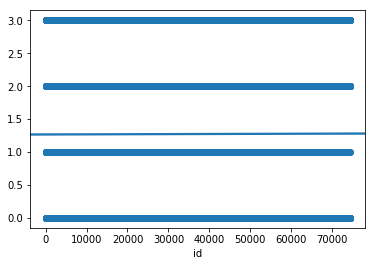

In [35]:
ax = sns.regplot(full.id, encode(full.status_group))

Doesn't look that way, so there's no detectable leakage.  Hence we'll delete ID from the data.

In [0]:
full = full.apply(encode)

In [37]:
full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
0,69572,6000.0,20110314,1548,1390,1706,34.938093,-9.856322,45683,0,...,6,2,1,1,8,6,0,1,0,1
1,8776,0.0,20130306,522,1399,610,34.698766,-2.147466,45426,0,...,6,2,2,2,5,3,1,1,0,1
2,34310,25.0,20130225,924,686,2296,37.460664,-3.821329,17767,0,...,6,2,1,1,0,1,1,2,0,0
3,67743,0.0,20130128,1961,263,2078,38.486161,-11.155298,45537,0,...,6,2,0,0,3,0,0,2,2,0
4,19728,0.0,20110713,20,0,133,31.130847,-1.825359,43411,0,...,6,2,3,3,5,3,1,1,0,1


The for loop below spuriously raises setting with copy warnings so to tidy the notebook we will temporarily turn off the chained assignment warning

In [0]:
pd.options.mode.chained_assignment = None

In [39]:
for col in sorted(null_cols):
    print(f"Processing column: {col}")
    
    encoded_none = full.loc[first_null_idx[col], col]
    
    train_row_index = full[col] != encoded_none
    test_row_index = full[col] == encoded_none
    
    train = full.loc[train_row_index, :]
    target = full.loc[test_row_index, :]
    
    train = reduce_mem_usage(train)
    target = reduce_mem_usage(target)
    X = train.drop(col, axis=1)
    y = train[col]
    X_target = target.drop(col, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size= 0.1)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print(acc_score)
    if acc_score > 0.5:
        prediction = rfc.predict(X_target)
        result = pd.Series(prediction)
        result.index = X_target.index
        target.loc[:, col] = result
        full = pd.concat([train, target], axis=0)
    else:
        print(f"{col} accuracy too low, use fillna instead.")

Processing column: funder
0.8884587813620072
Processing column: installer
0.9146586345381527
Processing column: permit
0.9787113255747942
Processing column: scheme_management
0.9893387120011525
Processing column: scheme_name
0.9052874743326489


In [0]:
pd.options.mode.chained_assignment = 'warn'

In [41]:
full.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
0,69572,6000.0,20110314,1548,1390,1706,34.93750,-9.859375,45683,0,...,6,2,1,1,8,6,0,1,0,1
2,34310,25.0,20130225,924,686,2296,37.46875,-3.822266,17767,0,...,6,2,1,1,0,1,1,2,0,0
5,9944,20.0,20110313,1105,0,442,39.18750,-4.765625,44150,0,...,4,4,1,1,4,2,2,2,0,0
13,50495,0.0,20130315,872,1368,1043,37.09375,-3.181641,14492,0,...,6,2,1,1,8,6,0,1,0,0
14,53752,0.0,20121020,130,0,2197,34.37500,-3.628906,37185,0,...,6,2,1,1,7,5,0,4,0,0


In [42]:
full.apply(decode).head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
0,69572,6000.0,20110314,Roman,1390,Roman,34.93750,-9.859375,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional,True
2,34310,25.0,20130225,Lottery Club,686,World vision,37.46875,-3.822266,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,functional,False
5,9944,20.0,20110313,Mkinga Distric Coun,0,DWE,39.18750,-4.765625,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,functional,False
13,50495,0.0,20130315,Lawatefuka Water Supply,1368,Lawatefuka water sup,37.09375,-3.181641,Kwa John Izack Mmari,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional,False
14,53752,0.0,20121020,Biore,0,WEDECO,34.37500,-3.628906,Mwabasabi,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,functional,False


In [0]:
test_code = d['status_group'].transform(['test'])[0]

In [0]:
full = full.reset_index(drop=True)

In [0]:
unlabelled_idx = full[full.status_group == 3].index
labelled_idx = full[full.status_group != 3].index

In [0]:
unlabelled_data = full.iloc[unlabelled_idx, :]
labelled_data = full.iloc[labelled_idx, :]

In [47]:
labelled_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
0,69572,6000.0,20110314,1548,1390,1706,34.93750,-9.859375,45683,0,...,6,2,1,1,8,6,0,1,0,1
1,34310,25.0,20130225,924,686,2296,37.46875,-3.822266,17767,0,...,6,2,1,1,0,1,1,2,0,0
2,9944,20.0,20110313,1105,0,442,39.18750,-4.765625,44150,0,...,4,4,1,1,4,2,2,2,0,0
3,50495,0.0,20130315,872,1368,1043,37.09375,-3.181641,14492,0,...,6,2,1,1,8,6,0,1,0,0
4,53752,0.0,20121020,130,0,2197,34.37500,-3.628906,37185,0,...,6,2,1,1,7,5,0,4,0,0


In [48]:
unlabelled_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,lake
28961,51630,0.0,20130204,507,1569,442,36.65625,-3.308594,7473,0,...,6,2,2,2,8,6,0,1,3,0
28962,49871,500.0,20130327,150,1260,164,35.00000,-10.953125,24521,0,...,6,2,1,1,8,6,0,1,3,0
28963,52449,0.0,20130304,507,1685,442,36.68750,-3.302734,34034,0,...,6,2,1,1,8,6,0,1,3,0
28964,28965,0.0,20130125,444,234,566,39.59375,-10.890625,20031,0,...,6,2,0,0,3,0,0,2,3,0
28965,36301,30.0,20130123,1961,584,1015,39.25000,-10.820312,23413,0,...,6,2,2,2,8,6,0,1,3,0


In [0]:
X = labelled_data.drop('status_group', axis=1)
y = labelled_data.status_group

In [0]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def scale_df(df, fit=True, scaler=MinMaxScaler([-1, 1]), scaler_type='minmax'):
    """
    Scale a dataframe using sklearn preprocessing scalers.
    
    Args:
        df: DataFrame to scale
        scaler_type: Type of scaling to use
        
    Returns:
        DataFrame with scaled values
        Scaler for later use (e.g. scaling additional features)
    """
        
    columns = df.columns
    index = df.index
    if fit:
        if scaler_type == 'robust':
            scaler = RobustScaler()
        elif scaler_type == 'standard':
            scaler = StandardScaler()
        else:
            scaler = MinMaxScaler([-1, 1])

        scaled_arr = scaler.fit_transform(df)
    else:
        scaled_arr = scaler.transform(df)
    
    scaled_df = pd.DataFrame(scaled_arr, columns=columns)
    scaled_df = scaled_df.set_index(index)
    
    return scaled_df, scaler

In [51]:
X.shape

(59400, 39)

As we're using an automated hyper parameter search, it is very easy to overfit the model.  To manage model variance we'll use cross validation to for the search.  (For convenience we'll just use it for the sklearn algorithms as the RandomizedSearchCV class makes this very easy to do.)

For XGB we'll use train_test_split to produce a test set and use that as the evaluation metric when fitting the model.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size= 0.2)

In [53]:
X_train, x_scaler = scale_df(X_train, fit=True, scaler_type='minmax')
X_test, x_scaler = scale_df(X_test, fit=False, scaler=x_scaler)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int32, int64, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
import xgboost as xgb

In [55]:
y_train.unique()

array([2, 0, 1])

In [0]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [57]:
print('Training XGB model...')
eval_set  = [( dtest, 'val')]
params = {'eta': 0.01,
          'gamma': 10,
          'max_depth': 6,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'objective': 'multi:softmax',
          'num_class': 3}

bst = xgb.train(params=params,
                dtrain=dtrain,
                evals=eval_set,
                early_stopping_rounds=5)

print('Predicting...')
errors = xgb.cv(params,
                dtest,
                nfold=5,
                verbose_eval=1)

loss = errors['test-merror-mean'].mean()
print(f'Loss: {loss:,.3f}')

Training XGB model...
[0]	val-merror:0.279545
Will train until val-merror hasn't improved in 5 rounds.
[1]	val-merror:0.279882
[2]	val-merror:0.276515
[3]	val-merror:0.276431
[4]	val-merror:0.274832
[5]	val-merror:0.274495
[6]	val-merror:0.274495
[7]	val-merror:0.273317
[8]	val-merror:0.274579
[9]	val-merror:0.275673
Predicting...
[0]	train-merror:0.276031+0.00285559	test-merror:0.281566+0.00793192
[1]	train-merror:0.277146+0.00429665	test-merror:0.281734+0.0110091
[2]	train-merror:0.274621+0.0052561	test-merror:0.280471+0.00611424
[3]	train-merror:0.274432+0.00478097	test-merror:0.280219+0.00723834
[4]	train-merror:0.274726+0.0056862	test-merror:0.279966+0.00758227
[5]	train-merror:0.274242+0.00566756	test-merror:0.279461+0.00675509
[6]	train-merror:0.273401+0.00569759	test-merror:0.279377+0.00742166
[7]	train-merror:0.27319+0.00482441	test-merror:0.27904+0.00740095
[8]	train-merror:0.273043+0.00581969	test-merror:0.278956+0.00792493
[9]	train-merror:0.272433+0.00506334	test-merror:0.

In [0]:
df = unlabelled_data.drop('status_group', axis=1)
dm = xgb.DMatrix(df)

In [0]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [0]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: "
                  f"{results['mean_test_score'][candidate]:.3f}"
                  f" (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}\n")

In [0]:
# Set hyperparameter search options.
# Limiting search to allow it to be run on Colab.
cv = 3
n_iter_search = 3

In [0]:
%%time
# specify parameters and distributions to sample from
svc_param_dist = {'C': np.logspace(0, 2, 6),
                  'cache_size': [5000],
                  'class_weight': ['balanced'],
                  'degree': [2, 3],
                  'gamma': np.logspace(0, 2, 6),
                  'kernel': ['linear',
                             'rbf',
                             'poly',
                             'sigmoid'],
                  'max_iter': [-1],
                  'probability': [False],
                  'random_state': [42],
                  'verbose': [1]}

# run randomized search
svc_random_search = RandomizedSearchCV(SVC(),
                                       param_distributions=svc_param_dist,
                                       n_iter=n_iter_search, cv=cv)

svc_random_search.fit(X, y)
report(svc_random_search.cv_results_)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [0]:
%%time
# specify parameters and distributions to sample from
lsvc_param_dist = {'C': np.logspace(0, 2, 6),
                   'class_weight': ['balanced'],
                   'loss': ['hinge'],
                   'max_iter': [10000],
                   'penalty': ['l2'],
                   'random_state': [42],
                   'verbose': [1]}

# run randomized search
lsvc_random_search = RandomizedSearchCV(LinearSVC(),
                                        param_distributions=lsvc_param_dist,
                                        n_iter=n_iter_search, cv=cv)

lsvc_random_search.fit(X, y)
report(lsvc_random_search.cv_results_)

In [0]:
%%time
# specify parameters and distributions to sample from

lrc_param_dist = {'C': np.logspace(0, 2, 6),
                  'class_weight': ['balanced'],
                  'max_iter': [5000],
                  'n_jobs': [4],
                  'penalty': ['l2'],
                  'random_state': [42],
                  'solver': ['newton-cg', 'lbfgs', 'sag']
                  'verbose': [1]}

# run randomized search
lrc_random_search = RandomizedSearchCV(LogisticRegression(),
                                       param_distributions=lrc_param_dist,
                                       n_iter=n_iter_search, cv=cv)

lrc_random_search.fit(X, y)
report(lsrc_random_search.cv_results_)

In [0]:
%%time
svc = LinearSVC(svc_random_search.best_params_)
svc.fit(X_test, y_test)

In [0]:
%%time
lsvc = LinearSVC(lsvc_random_search.best_params_)
lsvc.fit(X_test, y_test)

In [0]:
%%time
lrc = LogisticRegression(lrc_random_search.best_params_)
lrc.fit(X_test, y_test)

In [0]:
xgb_preds = d['status_group'].inverse_transform(bst.predict(dm).astype(int))
xgb_preds

In [0]:
svc_preds = d['status_group'].inverse_transform(svc.predict(df).astype(int))

In [0]:
lrc_preds = d['status_group'].inverse_transform(lrc.predict(df).astype(int))

In [0]:
voted_class = np.column_stack([xgb_preds, svc_preds, lsvc, lrc_preds])
voted_classes_df = pd.DataFrame(voted_class, columns=['xgb', 'svc', 'lsvc', 'lrc'])
voted_classes_df.head(20)

In [0]:
voted_class = voted_classes_df.mode(axis=1).iloc[:, 0]
voted_class.head(20)

In [0]:
voted_class.unique()

In [0]:
submission = submission_format.set_index('id')

In [0]:
submission['status_group'] = voted_class

In [0]:
submission

In [0]:
submission.to_csv('submission.csv')

In [0]:
submission.status_group.unique()